## **Proyecto de programación "Deep Vision in classification tasks Pre-entrenado"**

In [ ]:
%%capture
!pip freeze

Hola voy a ejecutar el comando ```!pip freeze``` para cotillear a Google Colab

In [ ]:
#Importemos TensorFlow 2.X y Numpy
import numpy as np
import tensorflow as tf
tf.__version__

'2.8.0'

## **- Cargando el conjunto de datos**

# Escritura de datos tomando como referencia un BASE_FOLDER

In [2]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Establezco una ruta absoluta a un directorio existente de mi Google Drive

BASE_FOLDER = "/content/drive/MyDrive/12MBID_Proyecto_Programacion_Colab/my_dataset/"

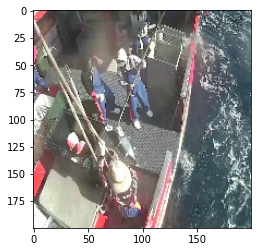

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Escogiendo y mostrando una imagen al azar del conjunto de test

indx = 12
img = cv2.imread(BASE_FOLDER + 'Train/ALB/img_00012.jpg', cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [ ]:
import os
categorias = []
categorias = os.listdir(BASE_FOLDER + 'Train/')
print(categorias)

['YFT', 'SHARK', 'OTHER', 'NoF', 'LAG', 'DOL', 'BET', 'ALB']


In [ ]:
# Generando datos con etiquetas a partir de imagenes  por cada categoria para el test
x_train =[]
y_train =[]

# Generando subcarpetas con imagenes  por cada categoria
idx = 0
for cat in categorias:
    parent_dir = BASE_FOLDER + "Train/"
    path = os.path.join(parent_dir, cat)
    # creamos las imagenes para el entranamiento redimensionandolos
    for imagen in os.listdir(path):
      img = cv2.imread(os.path.join(path, imagen))
      img = cv2.resize(img, (200,200))
      img = np.asarray(img)
      x_train.append(img)
      y_train.append(idx)
    idx += 1
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
print(x_train.shape)
print(y_train.shape)

(3404, 200, 200, 3)
(3404,)


In [ ]:
# Generando datos de entrenamiento extrayendo del directory Test/
x_test = []
y_test = []

idx = 0
for cat in categorias:
    parent_dir = BASE_FOLDER + "Test/"
    path = os.path.join(parent_dir, cat)
    # creamos las imagenes para el entranamiento redimensionandolos
    for imagen in os.listdir(path):
      img = cv2.imread(os.path.join(path, imagen))
      img = cv2.resize(img, (200,200))
      img = np.asarray(img)
      x_test.append(img)
      y_test.append(idx)
    idx += 1
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
print(x_test.shape)
print(y_test.shape)

(373, 200, 200, 3)
(373,)


In [ ]:
import pandas as pd
data_df = pd.DataFrame(y_test)
y_test = np.asarray(y_test)
print(y_test.shape)


(373,)


# Verificando las imagenes

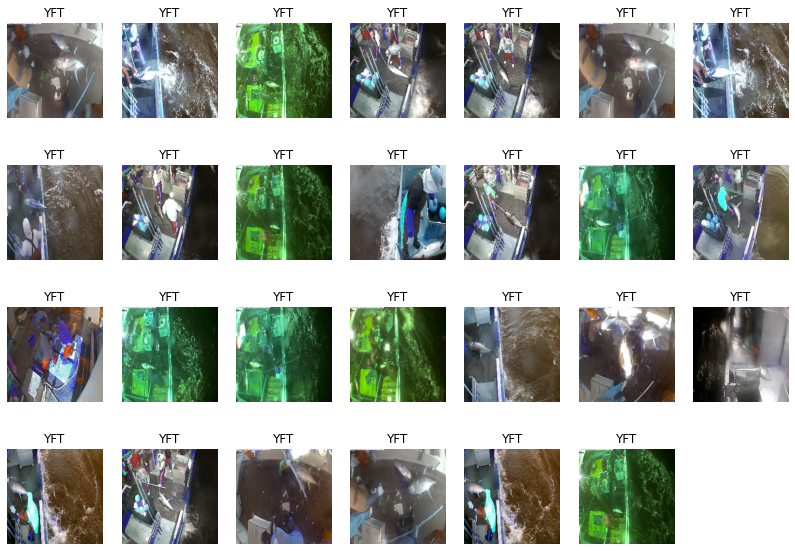

In [ ]:
fig = plt.figure(figsize=(14,10))
for i in range(1, 28):
  fig.add_subplot(4,7,i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i])
  plt.title(categorias[y_train[i]])
  plt.axis('off')


# TRABAJANDO CON REDES PRE-ENTRENADAS


## Acondicionamiento del conjunto de datos como en la VGG

In [ ]:

from tensorflow.keras.applications import imagenet_utils
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.backend import expand_dims

#One-hot encoding
lb = LabelBinarizer()
trainY = lb.fit_transform(y_train)
testY = lb.transform(y_test)

# IMPORTANTE: Se normalizan los datos como se normalizaron en el entrenamiento con ImageNet!!
trainX = imagenet_utils.preprocess_input(x_train)
testX = imagenet_utils.preprocess_input(x_test)

labelNames = categorias

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


(3404, 200, 200, 3)
(3404, 8)
(373, 200, 200, 3)
(373, 8)


## Creando un contenedor DataGenerator para el aumento automatico de muestras

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    # shear_range=0, # deslizamiento
    zoom_range=0.2, # rango de zoom
    # fill_mode='nearest', # como rellenar posibles nuevos pixeles
    # channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)

## Inspeccionando las muestras generadas sinteticamente

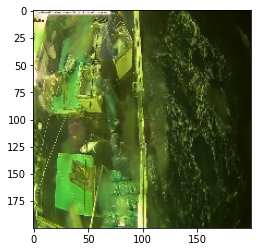

Label = YFT


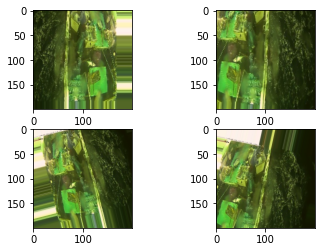

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

sample = 45
plt.imshow(image.array_to_img(trainX[sample]))
plt.show()
print('Label = {}'.format(labelNames[trainY[sample].argmax(axis=0)]))

fig, axes = plt.subplots(2,2)
i = 0
for batch in datagen.flow(trainX[sample].reshape((1,200,200,3)),batch_size=1):
    #plt.figure(i)
    axes[i//2,i%2].imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4:
        break
plt.show()

# Cargando la topologia de CNN (base model)

In [ ]:
#keras incluye varias arquitecturas
# VGG16, VGG19, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, RasNet
# documentacion https://keras.io/applications/
# Visual Geometry Group 16 / 19 (numero de layers)
# 1 y 2 en la competicion ImageNet 2014
# Kernels pequeños de 3x3

from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet',
                 include_top=False, # No incluir el top model, i.e. la parte densa destinada a la clasificación (fully connected layers)
                 input_shape=(200,200,3))
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

##  Creando el top model y congelando TODAS las capas convolucionales (TRANSFER LEARNING)

In [ ]:
# conectarlo a nueva parte densa
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dense(8, activation='softmax'))

pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 19,435,592
Trainable params: 4,720,904
Non-trainable params: 14,714,688
_________________________________________________________________


## Entrenando la Solucion

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
22/22 [==============================] - 38s 930ms/step - loss: 15.4111 - accuracy: 0.5986 - val_loss: 0.8578 - val_accuracy: 0.8605
Epoch 2/20
22/22 [==============================] - 14s 636ms/step - loss: 0.4734 - accuracy: 0.9141 - val_loss: 0.7814 - val_accuracy: 0.8811
Epoch 3/20
22/22 [==============================] - 14s 650ms/step - loss: 0.1049 - accuracy: 0.9791 - val_loss: 0.3969 - val_accuracy: 0.9413
Epoch 4/20
22/22 [==============================] - 15s 667ms/step - loss: 0.0249 - accuracy: 0.9952 - val_loss: 0.6112 - val_accuracy: 0.9325
Epoch 5/20
22/22 [==============================] - 15s 676ms/step - loss: 0.0298 - accuracy: 0.9967 - val_loss: 0.4064 - val_accuracy: 0.9501
Epoch 6/20
22/22 [==============================] - 15s 698ms/step - loss: 0.0128 - accuracy: 0.9985 - val_loss: 0.3362 - val_accuracy: 0.9559
Epoch 7/20
22/22 [==============================] - 16s 721ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.3007 - val_accuracy: 0.964

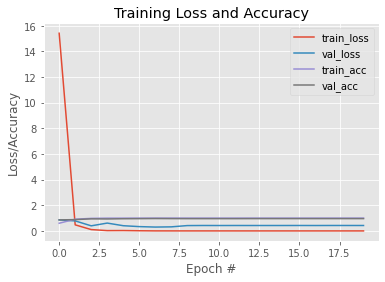

In [ ]:
# Import the necessary packages
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0005,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"])

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(trainX, trainY, batch_size=128, epochs=20, validation_split=0.2)
# Almaceno el modelo en Drive
# Montamos la unidad de Drive
# drive.mount('/content/drive')
# Almacenamos el modelo empleando la función mdoel.save de Keras
pre_trained_model.save(BASE_FOLDER+"deepCNN_FISH_pretrained.h5") #(X)

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(testX, batch_size=128)
# Sacamos el report para test
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
inputs = Input(shape=(trainX.shape[1], trainX.shape[2], trainX.shape[3]))
print(inputs.shape)

(None, 200, 200, 3)


# REDUCIENDO OVERFITTING MEDIANTE DATA AUGMENTATION

## Creando el top model y descongelando bloques convolucionales (FINE TUNING)

TensorFlow is already loaded. Please restart the runtime to change versions.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
27/27 [==============================] - 40s 1s/step - loss: 8.4299 - accuracy: 0.3193 - val_loss: 1.7380 - val_accuracy: 0.4584
Epoch 2/20
27/27 [==============================] - 39s 1s/step - loss: 1.6706 - accuracy: 0.4539 - val_loss: 1.6145 - val_accuracy: 0.4799
Epoch 3/20
27/27 [==============================] - 39s 1s/step - loss: 1.6459 - accuracy: 0.4548 - val_loss: 1.6424 - val_accuracy: 0.4584
Epoch 4/20
27/27 [==============================] - 39s 1s/step - loss: 1.6128 - accuracy: 0.4548 - val_loss: 1.5821 - val_accuracy: 0.4638
Epoch 5/20
27/27 [==============================] - 38s 1s/step - loss: 1.5825 - accuracy: 0.4595 - val_loss: 1.5259 - val_accuracy: 0.4799
Epoch 6/20
27/27 [==============================] - 38s 1s/step - loss: 1.5821 - accuracy: 0.4615 - val_loss: 1.5560 - val_accuracy: 0.4799
Epoch 7/20
27/27 [==============================] - 39s 1s/step - loss: 1.5983 - accuracy: 0.4568 - val_loss: 1.5974 - val_accuracy: 0.4799
Epoch 8/20
27/27 [==

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


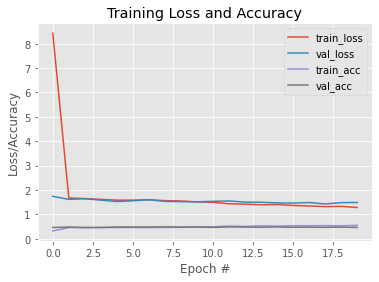

In [ ]:
# Imports que vamos a necesitar
%tensorflow_version 1.x
# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

#Cargamos el dataset CIFAR10
# (trainX, trainY), (testX, testY) = cifar10.load_data()
inputs = Input(shape=(trainX.shape[1], trainX.shape[2], trainX.shape[3]))
# Normalizamos las entradas de idéntica forma a como lo hicieron para entrenar la VGG16 en imageNet
trainX = imagenet_utils.preprocess_input(x_train)
testX = imagenet_utils.preprocess_input(x_test)

# Definimos dimensiones de nuestros datos de entrada y lista con las categorias de las clases
input_shape = (200, 200, 3)
# labelNames = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"]
labelNames = categorias
# En caso de inestabilidades numéricas pasar datos a one-hot encoding
trainY = to_categorical(y_train)
testY = to_categorical(y_test)

# Importamos VGG16 con pesos de imagenet y sin top_model especificando tamaño de entrada de datos
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
# Mostramos la arquitectura
base_model.summary()

# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# En base_model.layers.name tenemos la información del nombre de la capa
for layer in base_model.layers:
  if layer.name == 'block3_conv1':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', name='fc2')(x)
predictions = Dense(8, activation='softmax', name='predictions')(x)

model_aug = Model(base_model.input, outputs=predictions)


# Compilamos el modelo
# model_aug.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model_aug.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"])

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
# ¿tiene sentido en comparación al ejemplo de transfer learning?
model_aug.summary()

# Unimos las entradas y el modelo mediante la función Model con parámetros inputs y ouputs (Consultar la documentación)
# model_aug = Model(inputs=inputs, outputs=predictions)

# Entrenamos el modelo
# H = model_aug.fit(trainX, trainY, validation_split=0.2, batch_size=256, epochs=20, verbose=1)
H = model_aug.fit(datagen.flow(trainX, trainY, batch_size=128),  epochs=20, validation_data=(testX, testY))

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = model_aug.predict(testX, batch_size=64)
# Obtener el report de clasificación
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [4]:
name_IPYNB_file = 'Copia de 12MBID_Proyecto_Programacion_Entrega2.ipynb'
get_ipython().system(
        "apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended >> /dev/null"
    )
get_ipython().system(
            "jupyter nbconvert --output-dir='$BASE_FOLDER' '$BASE_FOLDER''$name_IPYNB_file' --to pdf"
        )





E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern '$BASE_FOLDER$name_IPYNB_file' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of pro